# **Milestone 4: Processing Pipeline and Baseline Model**
## Classifying Bird Song in Europe

Sandra Forro, Imran Naskani, Erin Rebholz

# **I. Problem Statement Refinement**

The aim of this project is to **Classify Top Bird Songs in Europe**. 2,901 15 second song recordings of the top 10 European bird species were subsetted from the Bird sound collection of Xeno-canto (XC), the Foundation for Nature Sounds in the Netherlands. The number of samples are approximately 200 per bird type, with small upward or downward deviations. Success is defined as surpassing the 85% accuracy that the Nature and Biodiversity Conservation Union (NABU)'s model achieves.

### **0. Imports and Initialization**

In [1]:
!pip install tensorflow-io

In [2]:
#!pip install numba

In [3]:
#!pip install librosa

In [4]:
#Utilities
import os
import time
import pathlib
import requests

#General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

#Multimedia
import imageio  #image utility
from scipy.io import wavfile  #wav image utility
import matplotlib.image as mpimg  #image utility

import librosa  #mp3 utility

import gc #To clear unused memory
import tensorflow as tf

import tensorflow_io as tfio
from IPython.display import Audio

from scipy.io.wavfile import read, write
from sklearn.metrics import f1_score


In [5]:
# Check if GPU is available and visible to TensorFlow
import tensorflow as tf

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


**Setting paths to access data file**

In [6]:
#cd /mnt/g/My Drive/Harvard_colab/CS109B/data

In [7]:
#For google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:

#Define base path with locations of text files
#Erin's
base_path = "/content/drive/My Drive/Harvard_colab/CS109B/data/"  #colab
#base_path = r"G:/My Drive/Harvard_colab/CS109B/data"  #local from windows
#base_path = "/mnt/g/My Drive/Harvard_colab/CS109B/data/"  #local from WSL to g drive

#Sandra's
#directory = '/content/drive/MyDrive/CS109B/data/mp3'

# **II. Data Exploration and Processing Refinement**

### Key Findings

1.   Audio must be converted into a tensor for effective processing

2.   Each audio has its own sampling rate, which needs to be standardized across all audios. This is done through resampling.

3. Audios can come with one or two channels. All audios must therefore must be standardized into one channel by taking the mean of the two channels.

4. Some audios are quiet/far away from the bird. In order to compare audios effectively, the files must be normalized in a range of -1 to 1, where the maximum amplitude is used as basis.

5. Long tails of silence can occur both at the start and/or end of audios. This causes discrepencies in the appearance of signals; trimming is applied to keep only the parts where the bird sings.

6. Adding padding to reach the specified length of 15 seconds across all audios equally results in long tails of silence. Instead, audio looping is utilized. Padding also requires resizing (padding) of images at the time of model input, which is an extra pre-processing step that results in a sub-optimal visualization. Looping eliminates this need as all image acquire the same dimensions.

7. Final image generation: a mel spectrogram in decibals is the most aligned with the human auditory system's perception of sound and creates the clearest image compared to the other alternatives tested (spectrogram, spectrogram in decibals, mel spectrogram not in decibals).

These findings are represented in the visualizations below, where the first image shows the trimmed and normalized audio in green, and the second illustrates the effectiveness of mel spectrograms vs. spectrograms and how they compare to an audio signal that is only in the time domain (Normalized_Audio).

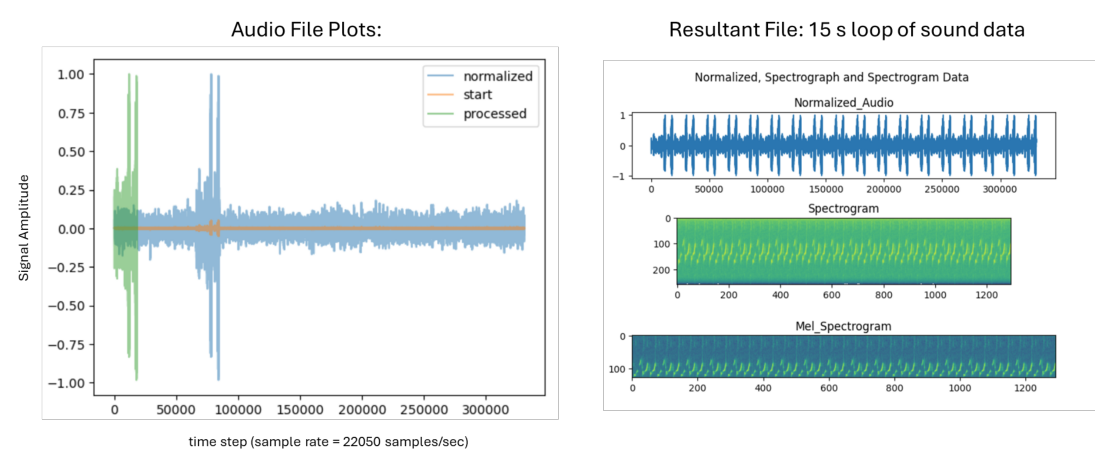

In [9]:
img = mpimg.imread(os.path.join(base_path,'figures/preprocessing.png'))
plt.figure(figsize=(14, 10))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

### **1. Audio Processing: Single Sample Test**

In this section, the effect of audio processing is tested in order to build a pipeline. This entails loading the audio into tensors and observing the effects of different pre-processing techniques that are applied. Finally, spectrograms, mel spectrograms and mel spectrograms in decibal scale are compared to choose a final input format for the model.

https://www.tensorflow.org/io/tutorials/audio <br>
https://www.geeksforgeeks.org/audio-data-preparation-and-augmentation-in-tensorflow/

#### Key elements
```
audio.rate
```
Each audio has its own inherent sampling rate, which is dependent on how the recording originated. Since the sampling rate affects the appearance of audio signals, we standardize the sampling rate across all recordings. This is done using resampling.

```
tfio.audio.resample(audio_tensor, rate_in=audio_sampling_rate, rate_out=samp_rate)
```
Each audio is resampled by providing its original sampling rate (`rate_in`) and specifying the desired target rate (`rate_out`).




```
tf.cast(audio_tensor, tf.float32)
```
While MP3s are the the predominant file type, there are some WAVs. In order to process WAVs, which are originally of dtype `int16`, they need to be converted into `float64` (MP3s are already in this format).




```
tf.reduce_mean(audio_tensor,-1)
```
Audio channels are standardized to 1, as not all audios have 2 channels (left and right inputs). The mean of both channels is computed.

* Reduces input_tensor along the dimensions given in axis by computing the mean of elements across the dimensions in axis. Unless keepdims is true, the rank of the tensor is reduced by 1 for each of the entries
in axis, which must be unique. If keepdims is true, the reduced dimensions are retained with length 1.
* https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean



```
audio_tensor = tf.squeeze(audio_tensor, axis=-1)
```
Reducing the two-channelled files returns a tensor of shape (audio,), which is appropriate for conversion into the format expected for our processing. The one-channelled files have the shape (audio, 1) originally, which must be reshaped into (audio,).

* Returns A Tensor. Has the same type as input. Contains the same data as input,
but has one or more dimensions of size 1 removed.

* https://www.tensorflow.org/api_docs/python/tf/squeeze





```
librosa.util.normalize(audio_tensor)
```
Adjusts the audio range to be between -1 and 1, so that quieter files are comparable to louder ones.


```
tfio.audio.trim(normalized_audio, axis=0, epsilon=0.2)
```
Trims silence from the audio. `axis=0` specifies that this is to be done along the time dimension, while `epilson` controls the threshold amplitude; anything below it is trimmed. There are several long tails of silence in the files.






```
tfio.audio.spectrogram(normalized_audio, nfft=2048, window=512, stride=128)
```
Spectrograms allow the representation of time and frequency together. The signal (time) domain is automatically extracted from raw audio, yet to get it in both time and frequency domain, a Short-Time Fourier Transform (STFT) is applied. This permits visualizing the contribution of frequency bands at different points in time. The y axis is frequency (in Herz), while the x axis characterizes the time.

The parameters used here are: <br>
* `nfft` the number of data points used in each block of the Fast Fourier Transform (FFT) when computing the spectrogram.
* `window` the size of the window function applied to each frame of the audio signal before computing the spectrogram. It determines the time resolution of the spectrogram.
* `stride` the number of samples by which the window moves between consecutive frames when computing the spectrogram. It determines the amount of overlap between adjacent frames.

To understand these, the concept of windowing should be known.

The windowing function takes each frame before feeding it into the STFT. It eliminates the samples which are at the endpoints of a frame. Removing endpoints minimizes spectral leakage. However, since these windows now consist of modified signals, signal is lost between the different frames. Overlapping frames are used to prevent this loss. Stride is what refers to the overlap in frames.

* https://www.tensorflow.org/io/api_docs/python/tfio/audio/spectrogram

```
tfio.audio.melscale(spectrogram, rate=samp_rate, mels=128, fmin=1000, fmax=8000)
```

```
tfio.audio.dbscale(mel_spectrogram, top_db=70)
```


Mel spectrograms are obtained by applying a series of transformations to the spectrogram, resulting in a representation that is more aligned with the human auditory system's perception of sound. The key transformation involves converting the linear frequency scale of the spectrogram to a logarithmic scale that approximates the human perception of pitch. Visually, mel spectrograms are clearer for model input.

The mel spectrograms are converted into deicbels (dB) scale, which is further more aligned to human perception.

Parameters:


*   `rate` the sampling rate of the audio signal, used to compute the frequency range of the spectrogram
*   `mels` this parameter determines the resolution of the Mel spectrogram in the frequency domain.
* `fmin` the lower bound of the frequency range considered in the Mel scale.
* `fmax` the upper bound of the frequency range considered in the Mel scale
* `top_db` (for scaling to dB) values above `top_db` are clipped to this maximum value to prevent very loud sounds from dominating the visualization. During fine-tuning, a range of 60-80 produced good results; visualizations were clearer. Values outside the range resulted in lower visibility.
* https://www.tensorflow.org/io/api_docs/python/tfio/audio/melscale




### **Single Sample Process**

In [10]:
# Other files used for testing

# 2992196700.mp3 # 5 sec
# 2243869220.mp3 # 5 sec
# 2534094571.mp3 # 5 sec

# 2534093991.mp3 # 3 sec
# 2609683982.mp3 # 9 sec
# 3353656819.mp3 # 15 sec
# 2432439334.mp3 # 15 sec

In [11]:
# run this
#filename = 2243609577 #2609683982
filename = 3353656819 # mp3 file
#filename = 4173213196 #wav
samp_rate = 22050 # hyperparameter to standardize the sampling rate across all recordings
sec_to_keep = 15 # our project scope is limited to 15 second recordings
desired_length = samp_rate * sec_to_keep # based on the samp_rate and sec_to_keep, we have a final length

In [12]:
# run this
audio = tfio.audio.AudioIOTensor(os.path.join(base_path,f"mp3/{filename}.mp3")) #mp3 test
#audio = tfio.audio.AudioIOTensor(os.path.join(base_path,f"wav/{filename}.wav"))#, dtype=float)  #wav test
audio_sampling_rate = audio.rate.numpy()
audio_tensor = audio.to_tensor()

In [13]:
audio_tensor

<tf.Tensor: shape=(720900, 2), dtype=float32, numpy=
array([[ 0.00272378,  0.00260272],
       [ 0.00302854,  0.00278186],
       [ 0.00241834,  0.00221348],
       ...,
       [-0.00334403, -0.00199874],
       [-0.00366453, -0.00234853],
       [-0.00277777, -0.0012153 ]], dtype=float32)>

In [14]:
audio_tensor=tf.cast(audio_tensor, tf.float32) #/ 32768.0 # necessary for WAV files, MP3s are already float32

In [15]:
audio_sampling_rate  # sampling rate specific to each audio file, necessary for conversion to a chosen sampling rate

48000

Some audios have 2 channels for the left and right ear, characterized by a rank of 2:

In [16]:
audio_tensor.shape

TensorShape([720900, 2])

**Center along mean, reduce to a single dimension/flatten, then reformat with appropriate sample rate**

Handle channels: if the file is  two-channelled, convert it into one channel. Else, the file is one-channeled and must be reshaped into (audio,).

In [17]:
if len(audio_tensor.shape) > 1 and audio_tensor.shape[-1] == 2:
    audio_tensor = tf.reduce_mean(audio_tensor,-1)
else:
    audio_tensor = tf.squeeze(audio_tensor, axis=-1)

In [18]:
audio_tensor.shape

TensorShape([720900])

Convert to a sampling rate that will be the same across all audios.

In [19]:
#Adjust sampling rate to the rate in the file
audio_tensor = tfio.audio.resample(audio_tensor, rate_in=audio_sampling_rate, rate_out=samp_rate)

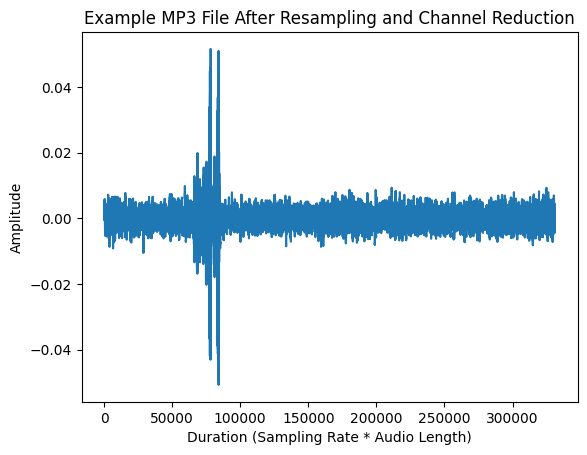

In [20]:
plt.plot(audio_tensor)
plt.xlabel('Duration (Sampling Rate * Audio Length)')
plt.ylabel('Amplitude')
plt.title('Example MP3 File After Resampling and Channel Reduction')
plt.show()

**Normalization (1, -1)**

In [21]:
normalized_audio = librosa.util.normalize(audio_tensor)

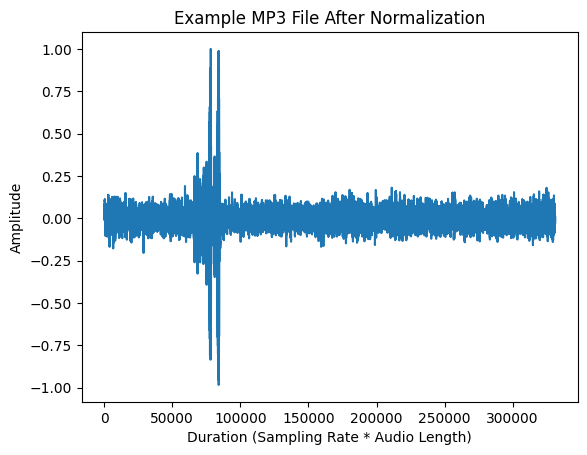

In [22]:
plt.plot(normalized_audio)
plt.xlabel('Duration (Sampling Rate * Audio Length)')
plt.ylabel('Amplitude')
plt.title('Example MP3 File After Normalization')
plt.show()

**Removing Silence**

In order to remove long tails of silence from audios, which will allow the model to concentrate on the essential instead, the `trim` method is used. It returns the starting and stopping position that characterizes the final trimmed audio.

In [23]:
position = tfio.audio.trim(normalized_audio, axis=0, epsilon=0.2)
print(position)

tf.Tensor([66285 84660], shape=(2,), dtype=int64)


In [24]:
start = position[0]
stop = position[1]
print(start, stop)

tf.Tensor(66285, shape=(), dtype=int64) tf.Tensor(84660, shape=(), dtype=int64)


The normalized audio file is sliced to contain only the sound with amplitude beyond the threshold epsilon.

In [25]:
processed = normalized_audio[start:stop]

Below, the unprocessed audio (orange) is compared to the normalized (blue) and finally normalized and trimmed (green) audios.

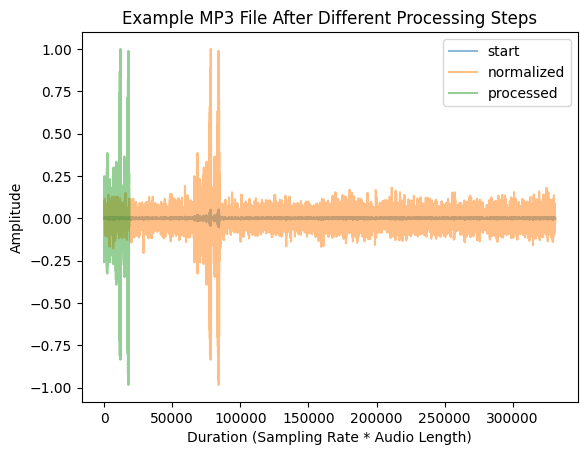

In [26]:
plt.plot(audio_tensor, alpha = .5,label = 'start')
plt.plot(normalized_audio, alpha = .5,label = 'normalized')
plt.plot(processed, alpha = .5, label = 'processed')
plt.legend()
plt.xlabel('Duration (Sampling Rate * Audio Length)')
plt.ylabel('Amplitude')
plt.title('Example MP3 File After Different Processing Steps')
plt.show()

**Make it loop every 15 sec**

As an alternative to padding audio of insufficient length, which results in long tails of silence, we improve the model input by looping the audio instead.

In [27]:
epsilon = 0.2  #Filters out baseline noise
spec_nftt = 512
spec_window =512
spec_stride = 256
mel_mels = 128
mel_fmin = 1000
mel_fmax = 8000
db_scale_top_db = 70

In [28]:
if processed.shape[0]< desired_length:
    loops = desired_length//processed.shape[0]+1
    audio_sample_new = np.zeros((loops*processed.shape[0],1)).astype('float32')

    for l in range(loops):
        audio_sample_new[len(processed)*l:(len(processed)*l+len(processed)),0] = processed

    #clip to desired length and save
    audio_sample = audio_sample_new[:desired_length]
    #write(os.path.join(base_path,f'15s/audio/{filename}.wav'), samp_rate,audio_sample[:,0])

    #Create spectrogram
    spectrogram = tfio.audio.spectrogram(audio_sample[:,0], nfft=spec_nftt, window=spec_window, stride=spec_stride)

elif audio_sample.shape[0]>= desired_length:
    audio_sample= processed[:desired_length]
    #Create spectrogram
    spectrogram = tfio.audio.spectrogram(audio_sample, nfft=spec_nftt, window=spec_window, stride=spec_stride)
    #save copy of file
    #write(os.path.join(base_path,f'15s/audio/{filename}.wav'), samp_rate,audio_sample)

**Spectrogram & Mel Spectrogram**

Spectrograms are a means to visualize audio in both the time and frequency dimension. Based on the results below, mel spectrograms in decibals provide the clearest and most interpretable images for both humans and a model.


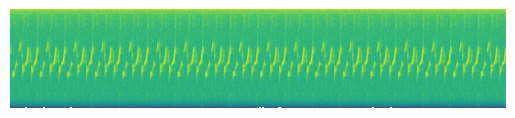

In [29]:
#spectrogram = tfio.audio.spectrogram(processed, nfft=spec_nftt, window=spec_window, stride=spec_stride)

#Imran's
#spectrogram = tfio.audio.spectrogram(normalized_audio, nfft=2048, window=512, stride=128)

plt.figure()
plt.axis('off')
plt.imshow(tf.math.log(spectrogram).numpy().T);

In [30]:
inv_spectrogram = tfio.audio.inverse_spectrogram(
    spectrogram, nfft=spec_nftt, window=spec_window, stride=spec_stride, iterations=30)

#Play the file
Audio(inv_spectrogram, rate=samp_rate)

In [31]:
#Audio(normalized_audio, rate=samp_rate)
#Audio(audio_tensor, rate=samp_rate)
Audio(processed, rate=samp_rate)

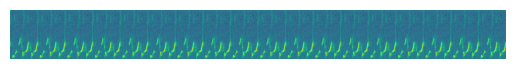

In [32]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=samp_rate, mels=128, fmin=1000, fmax=8000)

plt.figure()
plt.axis('off')
plt.imshow(tf.math.log(mel_spectrogram).numpy().T);

**dbscale**
https://www.tensorflow.org/io/api_docs/python/tfio/audio/dbscale

input	A spectrogram Tensor.
top_db	Minimum negative cut-off max(10 * log10(S)) - top_db
name	A name for the operation (optional).

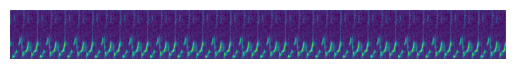

In [33]:

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=70)

plt.figure()
plt.axis('off')
plt.imshow(dbscale_mel_spectrogram.numpy().T);

In [34]:
dbscale_mel_spectrogram.numpy().shape

(1292, 128)

**Audio Play at Various Stages**

In [35]:
#Play the file
#Audio(normalized_audio, rate=samp_rate)
#Audio(audio_tensor, rate=samp_rate)
Audio(processed, rate=samp_rate)

### **2.  Generate Set of  Samples**

In [36]:
#Import meta data file
song_top10_df = pd.read_csv(os.path.join(base_path,"song_top10_df.csv"), index_col = 0)

**Audio and Mel-Spectrogram: Generator Function**

In [37]:
samp_rate = 22050
sec_to_keep = 15
epsilon = 0.2
spec_nftt = 512
spec_window =512
spec_stride = 256
mel_mels = 128
mel_fmin = 500
mel_fmax = 8000
db_scale_top_db = 80
folder_name = 'wip/'


def bird_pipe(song_top10_df,
              samp_rate = 22050,
              sec_to_keep = 15,
              epsilon = 0.2,
              spec_nftt = 512,
              spec_window =512,
              spec_stride = 256,
              mel_mels = 128,
              mel_fmin = 500,
              mel_fmax = 8000,
              db_scale_top_db = 80,
              folder_name = 'wip/'):

  except_gbid = []
  except_df_idx = []

  desired_length = samp_rate * sec_to_keep

  #Director to save work products
  mel_spec_dir = os.path.join(base_path,f'{folder_name}/mel_spec/')

  for i in tqdm(range(len(song_top10_df))):
      try:
          filename = song_top10_df.iloc[i,0]
          #Open file
          if song_top10_df.iloc[i,2] == 'audio/mpeg':
              audio = tfio.audio.AudioIOTensor(os.path.join(base_path,f'mp3/{filename}.mp3'))
              audio_sample = audio.to_tensor()
          else:
              audio = tfio.audio.AudioIOTensor(os.path.join(base_path,f'wav/{filename}.wav'))
              audio_sample = audio.to_tensor()
              audio_sample = tf.cast(audio_sample, tf.float32)

          audio_sampling_rate = audio.rate.numpy()

          #Flatten and mean balance
          if len(audio_sample.shape) > 1 and audio_sample.shape[-1] == 2:
              audio_sample = tf.reduce_mean(audio_sample,-1)
          else:
              audio_sample = tf.squeeze(audio_sample, axis=-1)


          #Adjust sampling rate to the rate in the file
          audio_sample = tfio.audio.resample(audio_sample, rate_in=audio_sampling_rate, rate_out=samp_rate)

          #Normalize (1, -1)
          audio_sample = librosa.util.normalize(audio_sample)

          #Trim portions with low baseline noise/no bird sound
          position = tfio.audio.trim(audio_sample, axis=0, epsilon=epsilon)
          start = position[0]
          stop = position[1]
          audio_sample = audio_sample[start:stop]


          #Standardize file length by repeating or truncating:
          if audio_sample.shape[0]< desired_length:
              loops = desired_length//audio_sample.shape[0]+1
              audio_sample_new = np.zeros((loops*audio_sample.shape[0],1)).astype('float32')

              for l in range(loops):
                  audio_sample_new[len(audio_sample)*l:(len(audio_sample)*l+len(audio_sample)),0] = audio_sample

              #clip to desired length and save
              audio_sample = audio_sample_new[:desired_length]
              write(os.path.join(base_path,f'{folder_name}/audio/{filename}.wav'), samp_rate,audio_sample[:,0])

              #Create spectrogram
              spectrogram = tfio.audio.spectrogram(audio_sample[:,0], nfft=spec_nftt, window=spec_window, stride=spec_stride)

          elif audio_sample.shape[0]>= desired_length:
              audio_sample= audio_sample[:desired_length]
              #Create spectrogram
              spectrogram = tfio.audio.spectrogram(audio_sample, nfft=spec_nftt, window=spec_window, stride=spec_stride)
              #save copy of file
              write(os.path.join(base_path,f'{folder_name}/audio/{filename}.wav'), samp_rate,audio_sample)

          #Create mel_spectrogram
          mel_spectrogram = tfio.audio.melscale(spectrogram, rate=samp_rate, mels=mel_mels, fmin=mel_fmin, fmax=mel_fmax)

          #Generate a plot to save
          plt.figure(figsize=(10, 4))
          plt.imshow(tf.math.log(mel_spectrogram).numpy().T)
          plt.axis('off')
          mel_spec_file = os.path.join(mel_spec_dir, f"{filename}.jpeg",)
          plt.savefig(mel_spec_file, bbox_inches='tight')
          plt.close()  # Close the plot to prevent memory leaks

          #Filter out high db sounds
          mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=db_scale_top_db)

      except:
          except_gbid.append(song_top10_df.iloc[i,0])
          except_df_idx.append(i)

      if i % 100 == 0:
          gc.collect() # To clear unused memory after every 100 iterations

  return except_gbid, except_df_idx


In [38]:
### Uncomment if you want to generate new sample files
except_gbid, except_df_idx = bird_pipe(song_top10_df,
                                       samp_rate = 22050,
                                       sec_to_keep = 15,
                                       epsilon = 0.2,
                                       spec_nftt = 512,
                                       spec_window =512,
                                       spec_stride = 256,
                                       mel_mels = 128,
                                       mel_fmin = 500,
                                       mel_fmax = 8000,
                                       db_scale_top_db = 70,
                                       folder_name = 'wip/')

100%|██████████| 2901/2901 [15:10<00:00,  3.19it/s]


In [39]:
#Exceptions from above code = 46
len(except_gbid)

46

In [40]:
Audio(audio_sample[:,0], rate=samp_rate) #mp3 version
#Audio(audio_sample, rate=samp_rate)  #wav version

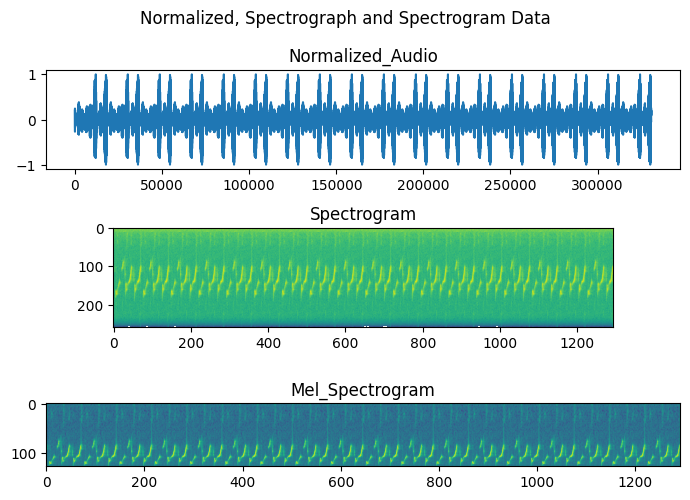

In [41]:
#Plot utility for a file
fig, axes = plt.subplots(3,1, figsize=(7, 5))
ax = axes.flatten()

ax[0].plot(audio_sample)
ax[0].set_title('Normalized_Audio')

#ax[1].axis('off')
ax[1].set_title('Spectrogram')
ax[1].imshow(tf.math.log(spectrogram).numpy().T);

#ax[2].axis('off')
ax[2].set_title('Mel_Spectrogram')
ax[2].imshow(tf.math.log(mel_spectrogram).numpy().T);

plt.suptitle(f'Normalized, Spectrograph and Spectrogram Data');
plt.tight_layout()

# **III. Baseline Model Selection and Justification**

Our baseline model uses a convolutional neural network (CNN) using the mel-spectrograms derived from our normalized audio data set.  The data is separated data train/validation cohort (80%) which is further separated to create a 20% validation set (16% of total) and 80% train set (74% of total). The test data set (20%) is reserved for our final model review and assessment.   

In order to prepare the data in batches to feed to the model, an ImageDataGenerator architecture is used to normalize image data to pixel ranges between 0-1, from 0-255.  This same architecture can be used to conduct more robust image augmentation to add additional samples to our model.  However, initial runs to augment the mel-spectragram with brightness changes and gaussian noise did not improve model performance.  Given the specialized nature of the mel-spectrogram images, the preprocessing steps used to create and normalize the mel-spectrums may be more effective to create additional batch files of our train and validation data sets for feed into the model, for instance generating images with differing parameter values in preprocessing to augment the sample.

The initial CNN model architecture contains a series of three successive pairs of convolution then max pooling layers to encode features and reduce dimensionality. After these layers, results are flattened and a dense layer is used, followed by a final dense layer with 10 nodes for each of our ten bird song classifications.  Categorical crossentropy loss function and adam optimizer on default settings are used.   ‘Relu’ activation layers are used on layers that require activation except the final layer, where a softmax layer is used.  This ‘vanilla’ CNN configuration is a simple CNN with which to benchmark other models.

The final train, test, and validation segments for each of the bird/song types and the CNN model baseline model architecture is as follows:


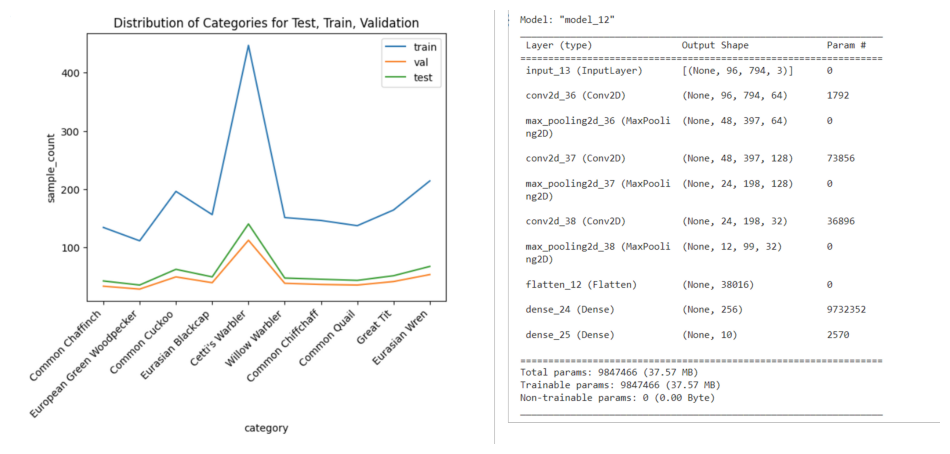

In [42]:
img = mpimg.imread(os.path.join(base_path,'figures/Baseline_cnn_model.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

### **3a.  Data Prep for CNN: Test, Train, Validation Split**

In [43]:
from sklearn.model_selection import train_test_split

**Catalogue Exceptions and Create a Dataframe for the CNN Model Generator**

In [44]:
#Output exceptions from last code run
song_top10_df.iloc[except_df_idx,0].to_csv(os.path.join(base_path,f'{folder_name}/exceptions.csv'))

#song_top10_df_exept = pd.read_csv(os.path.join(base_path,f'{folder_name}/excpetions.csv'))

In [45]:
#Add a test/train/validation/exception column to the song_top10_df:
song_top10_split_df = song_top10_df.copy()
cols_keep = ['gbifID','vernacularName']
song_top10_split_df = song_top10_split_df.loc[:,cols_keep]
song_top10_split_df['flag'] = [x in except_df_idx for x in song_top10_split_df.gbifID]

In [46]:
def train_val_test_split(dataset):
    temp_data, test_data = train_test_split(song_top10_split_df, test_size=0.2, stratify=song_top10_split_df['vernacularName'])
    train_data, val_data = train_test_split(temp_data, test_size=0.2, stratify=temp_data['vernacularName'])
    return train_data, val_data, test_data

In [47]:
train_data, val_data, test_data = train_val_test_split(song_top10_split_df[song_top10_split_df.flag != False])

In [48]:
#samples in train, val, test
len(train_data),len(val_data),len(test_data)

(1856, 464, 581)

In [49]:
#append Test/Train/Val to the 'Flag' Column
song_top10_split_df['train'] = [x in train_data.gbifID.values for x in song_top10_split_df.gbifID]
song_top10_split_df['test'] = [x in test_data.gbifID.values for x in song_top10_split_df.gbifID]
song_top10_split_df['val'] = [x in val_data.gbifID.values for x in song_top10_split_df.gbifID]

**Encode Labels / Categorical**

In [50]:
# encode labels
name_to_index = {name: i for i, name in enumerate(song_top10_split_df['vernacularName'].unique())}

In [51]:
name_to_index

{'Common Chaffinch': 0,
 'European Green Woodpecker': 1,
 'Common Cuckoo': 2,
 'Eurasian Blackcap': 3,
 "Cetti's Warbler": 4,
 'Willow Warbler': 5,
 'Common Chiffchaff': 6,
 'Common Quail': 7,
 'Great Tit': 8,
 'Eurasian Wren': 9}

In [52]:
song_top10_split_df['y'] = [str(name_to_index[x]) for x in song_top10_split_df['vernacularName']]

In [53]:
#Export to Dataframe
#song_top10_split_df.to_csv(os.path.join(base_path,f'{folder_name}/splits.csv'))

In [54]:
song_top10_split_df

,gbifID,vernacularName,flag,train,test,val,y
3597,2243569039,Common Chaffinch,False,False,True,False,0
3876,2243570573,European Green Woodpecker,False,True,False,False,1
4027,2243571423,Common Cuckoo,False,False,True,False,2
4050,2243571568,Eurasian Blackcap,False,True,False,False,3
4086,2243571757,Common Chaffinch,False,False,False,True,0
...,...,...,...,...,...,...,...
712063,4508374446,Common Quail,False,True,False,False,7
712966,4524630521,Cetti's Warbler,False,True,False,False,4
713079,4524631089,Cetti's Warbler,False,True,False,False,4
713129,4524631548,Cetti's Warbler,False,True,False,False,4


### **3b.  Data Prep for CNN: ImageGenerators for Model**  (CAN START HERE AFTER IMPORTS)

**Imports for section**

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [78]:
song_top10_split_df = pd.read_csv(os.path.join(base_path,'15s/splits_15.csv'), index_col = 0)  #Note this was our initial split file, so use it for all future values

index_to_name = {i: name for i, name in enumerate(song_top10_split_df['vernacularName'].unique())}
name_to_index = {name: i for i, name in enumerate(song_top10_split_df['vernacularName'].unique())}

folder_name = '15s/'

In [79]:
song_top10_split_df.y = song_top10_split_df.y.astype('string')

**Create DFs for Test/Train/Val**

In [80]:
#train
link = [os.path.join(base_path,f'{folder_name}/mel_spec/{i}.jpeg') for i in song_top10_split_df[song_top10_split_df.train==True].gbifID]
y_str = [i for i in song_top10_split_df[song_top10_split_df.train==True].y]  #needs to be a categorical value
traingen_df = pd.DataFrame({'x':link,'y':y_str})

#val
link = [os.path.join(base_path,f"{folder_name}/mel_spec/{i}.jpeg") for i in song_top10_split_df[song_top10_split_df.val==True].gbifID]
y_str = [i for i in song_top10_split_df[song_top10_split_df.val==True].y]  #needs to be a categorical value
valgen_df = pd.DataFrame({'x':link,'y':y_str})

#test
link = [os.path.join(base_path,f"{folder_name}/mel_spec/{i}.jpeg") for i in song_top10_split_df[song_top10_split_df.test==True].gbifID]
y_str = [i for i in song_top10_split_df[song_top10_split_df.test==True].y]  #needs to be a categorical value
testgen_df = pd.DataFrame({'x':link,'y':y_str})

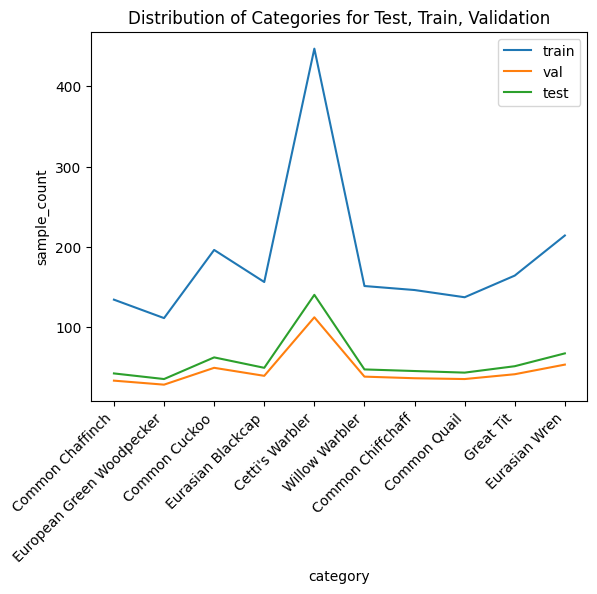

In [81]:
plt.plot(list(name_to_index.keys()),traingen_df.y.value_counts().sort_index(),label = 'train')
plt.plot(list(name_to_index.keys()),valgen_df.y.value_counts().sort_index(),label = 'val')
plt.plot(list(name_to_index.keys()),testgen_df.y.value_counts().sort_index(),label = 'test')
plt.xlabel('category')
plt.ylabel('sample_count')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Categories for Test, Train, Validation');

In [82]:
#Train baseline Accuracy:
baseline = traingen_df.y.value_counts().sort_index()
max_cat = np.max(baseline)/np.sum(baseline)
print(f'Naive baseline train accuracy: {max_cat:.2f}')

Naive baseline train accuracy: 0.24


In [83]:
# Imports PIL module
from PIL import Image

# open method used to open different extension image file
im = Image.open(valgen_df.iloc[0,0])
imnp = np.array(im)

# This method will show image in any image viewer
im.show()

In [84]:
imnp.shape

(96, 794, 3)

**Image Generator Code**

In [85]:
image_width = 794
image_height = 96

tf.random.set_seed(109)
np.random.seed(109)

train_batch_size = 16

# Generator for train and validation data
image_generator = ImageDataGenerator(
    rescale=1./255#,
    #rotation_range=5, # rotation
    #width_shift_range=0.1, # horizontal shift
    #height_shift_range=0.1, # vertical shift
    #zoom_range=0.1, # zoom
    #horizontal_flip=True, # horizontal flip
    #brightness_range=[0.1,1.1],
    #preprocessing_function=add_noise,
)

# Train data
train_data = image_generator.flow_from_dataframe(
    dataframe=traingen_df,
    x_col='x',
    y_col='y',
    #subset="training",
    batch_size=train_batch_size,
    seed = tf.random.set_seed(109),
    shuffle=True,
    class_mode="categorical",
    target_size=(image_width,image_height),
    color_mode="rgb"
)

# val data
val_data = image_generator.flow_from_dataframe(
    dataframe=valgen_df,
    x_col='x',
    y_col='y',
    #subset="training",
    batch_size=train_batch_size,
    seed = tf.random.set_seed(109),
    shuffle=False,
    class_mode="categorical",
    target_size=(image_width,image_height),
    color_mode="rgb"
)

# test data
test_data = image_generator.flow_from_dataframe(
    dataframe=testgen_df,
    x_col='x',
    y_col='y',
    #subset="training",
    batch_size=train_batch_size,
    seed = tf.random.set_seed(109),
    shuffle=False,
    class_mode="categorical",
    target_size=(image_width,image_height),
    color_mode="rgb"
)


train_data_count = train_data.samples
val_data_count = val_data.samples
test_data_count = test_data.samples
steps_per_epoch = np.int32(train_data_count / train_batch_size)

Found 1822 validated image filenames belonging to 10 classes.
Found 458 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 34 invalid image filename(s) in x_col="x". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 6 invalid image filename(s) in x_col="x". These filename(s) will be ignored.
  warnings.warn(


Found 575 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 6 invalid image filename(s) in x_col="x". These filename(s) will be ignored.
  warnings.warn(


In [86]:
train_data, val_data, test_data

(<keras.src.preprocessing.image.DataFrameIterator at 0x78d3e5869030>,
 <keras.src.preprocessing.image.DataFrameIterator at 0x78d4731ce770>)

In [87]:
train_data_count, val_data_count, test_data_count

(1822, 458, 575)

### **4. Baseline CNN Model**

In [88]:
from matplotlib import cm
import pickle
import time
from PIL import Image

#import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
#from tf_keras_vis.gradcam import Gradcam
#from tf_keras_vis.saliency import Saliency
#from tf_keras_vis.utils import normalize


In [89]:
# Baseline
input_dim = [96,794,3]
n_classes = 10
inputs = Input(shape=(input_dim))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

outputs = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 794, 3)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 794, 64)       1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 397, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 397, 128)      73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 198, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 198, 32)       3689

In [90]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_data,
          steps_per_epoch=train_data.samples//train_data.batch_size,
          epochs=10,
          validation_data=val_data,
          validation_steps=val_data.samples//val_data.batch_size,
          callbacks=es)

Epoch 1/10
113/113 [==============================] - 11s 87ms/step - loss: 1.9840 - accuracy: 0.3200 - val_loss: 1.6562 - val_accuracy: 0.4308
Epoch 2/10
113/113 [==============================] - 9s 83ms/step - loss: 1.2730 - accuracy: 0.5631 - val_loss: 1.2490 - val_accuracy: 0.5804
Epoch 3/10
113/113 [==============================] - 10s 84ms/step - loss: 1.0859 - accuracy: 0.6501 - val_loss: 1.1137 - val_accuracy: 0.6384
Epoch 4/10
113/113 [==============================] - 9s 83ms/step - loss: 0.9642 - accuracy: 0.6971 - val_loss: 1.1435 - val_accuracy: 0.6362
Epoch 5/10
113/113 [==============================] - 9s 82ms/step - loss: 0.8732 - accuracy: 0.7182 - val_loss: 1.0833 - val_accuracy: 0.6496
Epoch 6/10
113/113 [==============================] - 10s 84ms/step - loss: 0.8296 - accuracy: 0.7265 - val_loss: 1.0468 - val_accuracy: 0.6629
Epoch 7/10
113/113 [==============================] - 10s 85ms/step - loss: 0.7300 - accuracy: 0.7719 - val_loss: 1.0880 - val_accuracy: 0.

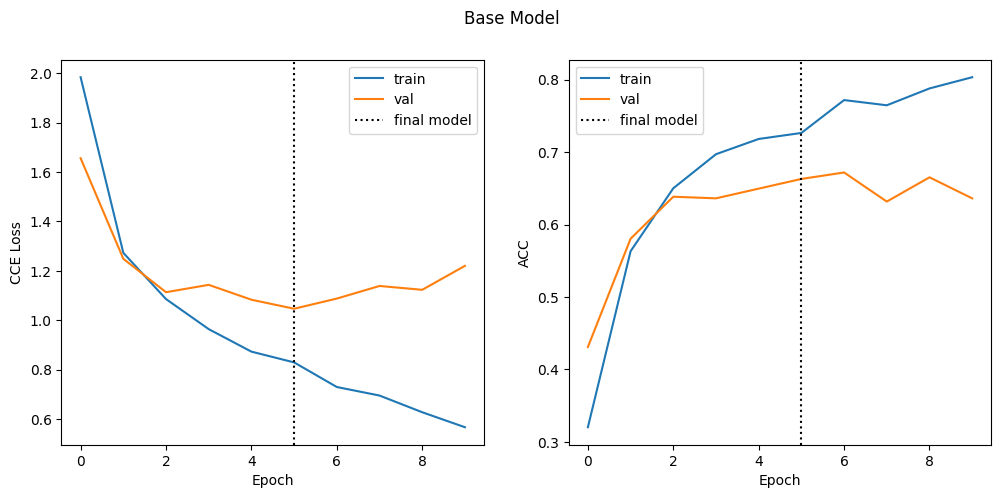

In [91]:
# Plot Model History
def plot_hist(model, title=None):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].plot(model.history.history['loss'], label='train')
    axs[0].plot(model.history.history['val_loss'], label='val')
    axs[0].axvline(np.argmin(model.history.history['val_loss']), c='k', ls=':', label='final model')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('CCE Loss')
    axs[0].legend()
    axs[1].plot(model.history.history['accuracy'], label='train')
    axs[1].plot(model.history.history['val_accuracy'], label='val')
    axs[1].axvline(np.argmin(model.history.history['val_loss']), c='k', ls=':', label='final model')
    axs[1].legend();
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('ACC')
    plt.suptitle(title)

plot_hist(model, 'Base Model')

In [92]:
val_overall = model.evaluate(val_data)
train_overall = model.evaluate(train_data)

114/114 [==============================] - 7s 65ms/step - loss: 0.4862 - accuracy: 0.8452


In [93]:
val_overall,train_overall

([1.203914761543274, 0.6397379636764526],
 [0.48619887232780457, 0.8452250361442566])

In [94]:
val_data.reset()
valpredict = model.predict(val_data,steps = np.ceil(val_data.samples/val_data.batch_size))


predicted_class=np.argmax(valpredict,axis=1)

labels = (val_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class]

filenames=val_data.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Fileshort":[f[-10:] for f in filenames],
                      "Predictions":predictions})

results['Actual']= [list(valgen_df[valgen_df.x == i].y.values)[0] for i in results.Filename]

results['Labels'] = val_data.labels
results.head(10)

29/29 [==============================] - 2s 65ms/step


,Filename,Fileshort,Predictions,Actual,Labels
0,/content/drive/My Drive/Harvard_colab/CS109B/d...,70573.jpeg,1,1,1
1,/content/drive/My Drive/Harvard_colab/CS109B/d...,71423.jpeg,2,2,2
2,/content/drive/My Drive/Harvard_colab/CS109B/d...,71757.jpeg,0,0,0
3,/content/drive/My Drive/Harvard_colab/CS109B/d...,22539.jpeg,5,5,5
4,/content/drive/My Drive/Harvard_colab/CS109B/d...,55060.jpeg,6,6,6
5,/content/drive/My Drive/Harvard_colab/CS109B/d...,63016.jpeg,6,0,0
6,/content/drive/My Drive/Harvard_colab/CS109B/d...,70743.jpeg,4,4,4
7,/content/drive/My Drive/Harvard_colab/CS109B/d...,93036.jpeg,4,4,4
8,/content/drive/My Drive/Harvard_colab/CS109B/d...,95232.jpeg,4,4,4
9,/content/drive/My Drive/Harvard_colab/CS109B/d...,95318.jpeg,4,4,4


**F1-Score**

In [95]:
f1 = []
count = []

labels_list = list(labels.values())

for i in range(len(labels_list)):
    val = results.Actual[results.Actual == labels_list[i]].dropna()
    pred = results.Predictions[results.Actual == labels_list[i]].dropna()
    helper = f1_score(val, pred, average = 'weighted')
    helper2 = len(val)
    f1.append(helper)
    count.append(helper2)

overall = f1_score(results.Actual, results.Predictions, average='weighted')

tags = [(t + f'; n={c}') for t,c in zip(list(name_to_index.keys()), count)]

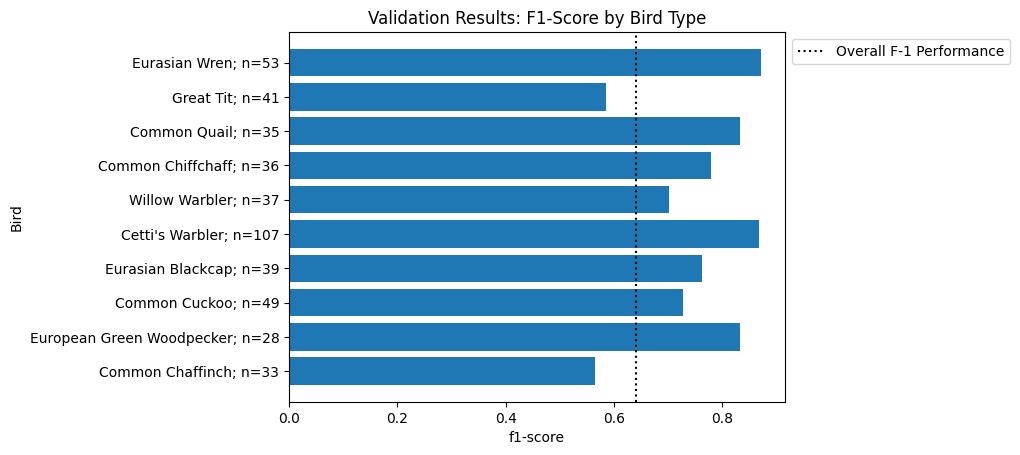

In [96]:
plt.barh(tags, f1)
plt.axvline(overall, label = 'Overall F-1 Performance', color = 'black', linestyle = ':')
plt.xlabel('f1-score')
plt.ylabel('Bird')
plt.title('Validation Results: F1-Score by Bird Type')
plt.legend(bbox_to_anchor=[1,1]);

# **IV. Results Interpretation and Analysis**

After 10 epochs of training, our baseline model accuracy was 64-67% on our validation set of data.  In the later epochs, we see a divergence between our train accuracy and validation results, indicating some overfitting. Deeper network architecture, experimenting with drop-out layers, hyper-paramter tuning (optimizers, initializations) will improve these results.  Additionally, transfer learning from other established network and additional sample generation using image augmentation techniques will also be explored.

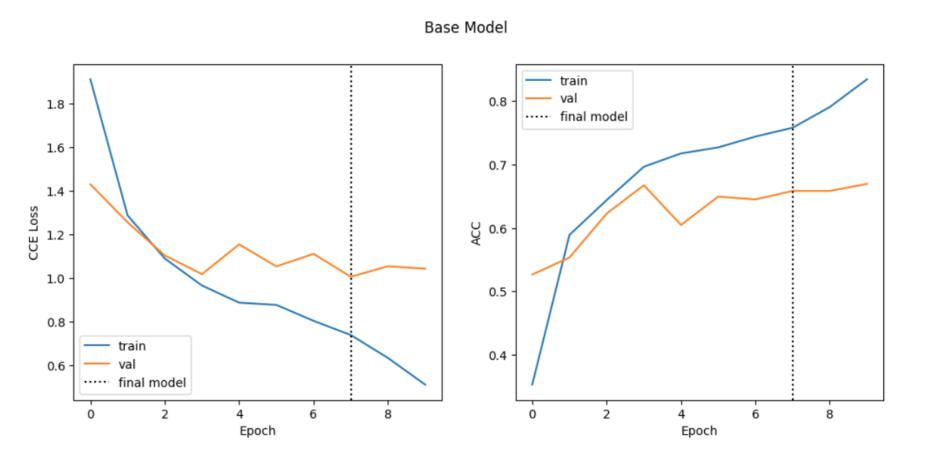

In [75]:
img = mpimg.imread(os.path.join(base_path,'figures/model_performance.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

Accuracy of the predictions by bird type were also explored by calculating the f1-score for each prediction category.  While the Cetti’s Warbler accounted for the largest sample volume, results for the warbler are not materially better than other smaller bird song categories.  That said, there are several categories that perform worse than others. Future iterations of model performance will be judged on the level of balance of predictions across all categories.

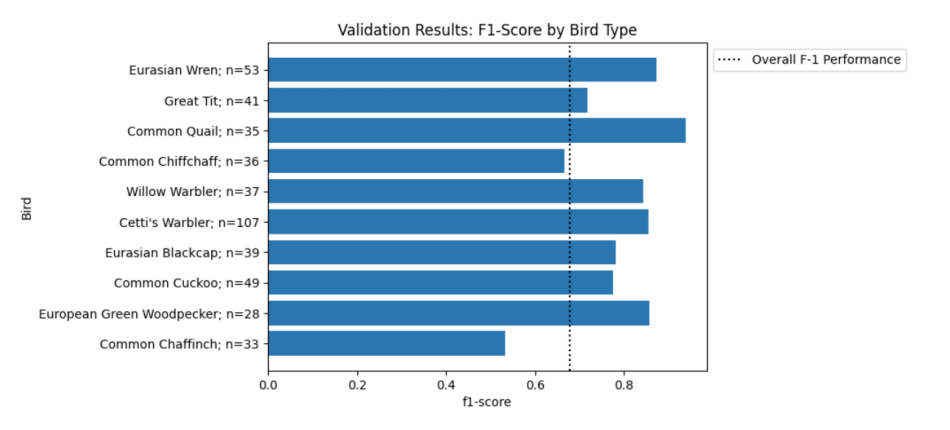

In [97]:
img = mpimg.imread(os.path.join(base_path,'figures/f1_score.png'))
plt.figure(figsize=(12, 8))
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

# **V. Final Model Pipeline Setup**

As we have seen so far, there are two major tasks at hand; first is pre-processing of the audio files to generate mel-spectrograms images, and then using these mel-spectrogram images to train our CNN model. To achieve this, one option could be to create a pipeline which would do the audio pre-processing to generate the mel-spectrograms on the fly and feed them to our CNN model in batches for training. The second approach could be to perform pre-processing and mel-spectrogram image generation as a function of its own and store them in a directory, followed by building a pipeline to feed those image to the CNN model for training. We have adopted the second approach since it is more time and resource efficient. This way the mel-spectrograms would need to be generated only once and after they are stored in the directory we do not need to run that portion of the code again and we can use resources efficiently to train the model from stored images, perform several iterations as well as try different models.

To build the modeling pipeline, we have used Image Data Generator. Currently, we are loading the mel-spectrogram images into 3 dataframes for training, validation and testing and then using flow_from_df() method to get these images in a batch size of 16. We are using validation set during model training to avoid data leakage and we will preserve the test data until we have a final model ready to test. The class_mode in the pipeline is set to 'categorical' since it is a classification problem. We are shuffling the data for training to reduce any bias. Another option which we could potentially explore in future is to directly load images using flow_from_directory() and avoid pre-loading of images into dataframe. Also in future we will try to change the color_mode from 'rgb' to 'grayscale' to see if it impacts postively on model performance. The Image Data Generator also gives us flexibility to perform data augmentation using various parameter for rotation, shifting, noise addition, flipping etc. At this step we are only using image rescaling as 1/255 to normalize the images but in future we will try other parameters as well as generating augmented images to balance the class of some low count classes.

In addition to exploring different parameters in the pipeline or model architectre, in the final submission we will also explore Transfer Learning, i.e. using a model with pre-trained weight and fine-tune it with our data.